# Configs

In [1]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from shapely.geometry import box
import contextily as ctx
from pyproj import Transformer
from adjustText import adjust_text
import geodatasets
# color and font
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
base_colors = [
        "#B6E3CE",
        "#D0E6A5",
        "#FFDD94",
        "#FA897B",
        "#CCABDB"]
N = 6 #len(new_regions)  # 1~7 共7类
cmap = LinearSegmentedColormap.from_list("custom_gradient", base_colors, N=N)
expanded_colors = [cmap(i) for i in np.linspace(0, 1, N)]
nodata_color = (1, 1, 1, 0)  # 完全透明
class_colors = [nodata_color] + expanded_colors
class_cmap = ListedColormap(class_colors[:N+1])
norm = BoundaryNorm(np.arange(-0.5, N+1, 1), class_cmap.N)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=expanded_colors)
plt.rcParams['font.family'] = 'monospace'
cmap_ = LinearSegmentedColormap.from_list("custom_gradient", base_colors)

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# classification (just for example)
def reclassify_values(value):
    if value <= -1:
        return '<=-1'
    elif value <= 0:
        return '-1~0'
    elif value <= 1:
        return '0~1'
    elif value <= 2:
        return '1~2'
    else:
        return '>2'

def plot_LCRPGR(gdf, filed, num='a', scale=1, classifier=reclassify_values, colors={
    '<=-1': "#B6E3CE",
    '-1~0': "#D0E6A5",
    '0~1': "#FFDD94",
    '1~2': "#FA897B",
    '>2': "#CCABDB"
},extra_polygon=None):

    gdf['reclassified'] = gdf[filed].apply(classifier)
    gdf['color'] = gdf['reclassified'].map(colors)
    categories = list(colors.keys())
    category_counts = gdf['reclassified'].value_counts(normalize=True) * 100
    percentages = [category_counts.get(cat, 0)
                   for cat in categories]  
    fig, ax1 = plt.subplots(1, 1, figsize=(
        8*scale, 4*scale), subplot_kw={'projection': ccrs.Mollweide()})
    if extra_polygon is not None:
        extra_polygon.plot(ax=ax1,edgecolor="black", facecolor="white",
            linewidth=0.5)
    for _, row in gdf.iterrows():
        # print(row['color'],row['reclassified'])
        ax1.add_geometries(
            [row.geometry],
            crs=ccrs.Mollweide(),
            facecolor=row['color'],
            edgecolor='black',
            linewidth=0.5
        )

    ax2 = fig.add_axes([0.3, 0.15, 0.4, 0.05])  # [left, bottom, width, height]
    ax2.set_xlim(0, 100.5)  
    ax2.axis('off') 

    cumulative_percentage = 0
    for category, percentage in zip(categories, percentages):
        ax2.barh(
            [0],  
            percentage,  
            left=cumulative_percentage,  
            color=colors[category],  
            height=1,
            edgecolor='black'  
        )
        if percentage > 1:
            ax2.text(
                cumulative_percentage + percentage / 2,  
                .6,  
                f"{category}\n{percentage:.1f}%",  
                ha='center', va='bottom', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='none',
                          boxstyle='round,pad=0.01')
            )
        cumulative_percentage += percentage  
    fig.tight_layout()
    ax2.set_position([0.1, 0.05, 0.8, 0.05])
    ax2.set_ylabel("Percentage of LCRPGR Group")

    ax1.text(
        0.07, 0.95, f"{num}",
        fontsize=15, color='black',
        ha='center', va='top',
        transform=ax1.transAxes,
        bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1')
    )
    
    ax1.set_global()
    return fig, ax1

In [3]:
def plot_values(gdf, field, num='a', scale=1, cmap=cmap_,vmax=1,vmin=0,unlim="neither"):
    fig, ax1 = plt.subplots(1, 1, figsize=(
        8*scale, 4*scale), subplot_kw={'projection': ccrs.Mollweide()})
    gdf.plot(
    column=field,       
    cmap=cmap_,         
    vmin=vmin, vmax=vmax,     
    linewidth=0.5, 
    edgecolor="black", 
    ax=ax1,
    legend=False,        
)

    cax = fig.add_axes([0.5, 0.15, 0.3, 0.03]) 
    sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []  

    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal",extend=unlim)
    cbar.ax.text(-0.07, 0.5, field,
             va='center', ha='right',
             rotation=0, fontsize=12,
             transform=cbar.ax.transAxes,bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1'))
    cbar.ax.xaxis.set_ticks_position("top")
    cbar.ax.xaxis.set_label_position("top")
    ax1.set_xlim(-18000000, 18000000)
    ax1.set_ylim(-9000000, 9000000)
    ax1.text(
        0.07, 0.95, f"{num}",
        fontsize=15, color='black',
        ha='center', va='top',
        transform=ax1.transAxes,
        bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1')
    )
    ax1.coastlines(linewidth=0.5)
    return fig, ax1


# Load Basic data

In [4]:
import pandas as pd
adm0 = gpd.read_file('temp/adm0_base.gpkg')
nrid2nregion = adm0.set_index('NRID')['NRegion'].to_dict()
nrid2nregion[2] = 'N. America & Europe'

# Indicators Calculation

In [5]:
Area_Prod = [
    'GHSL-S', 'GURS', 'GLC-FCS30D', 'GISA', 'GISD30', 'GAIA' 
]
Pop_Prod = ['GHS-POP', 'WorldBank', 'LandScan', 'WorldPop' ]

urban_columns = [col for col in adm0.columns if col.startswith('U_')]
pop_colums  = [col for col in adm0.columns if col.startswith('POP_')]
gdp_colums = [col for col in adm0.columns if col.startswith('GDP_')]

In [6]:
import warnings
from pandas.errors import PerformanceWarning
import numpy as np
warnings.simplefilter(action="ignore", category=PerformanceWarning)
for year in range(2000, 2021, 5):
    adm0[f'GDPPC_{year}_WorldBank'] = adm0[f'GDP_{year}_WorldBank'] / \
        adm0[f'POP_{year}_WorldBank']

for uprod in Area_Prod:
    for pprod in Pop_Prod:
        for year in range(2000, 2021, 5):
            adm0[f'BpC_{year}_{uprod}&{pprod}'] = adm0[f'U_{year}_{uprod}'] / \
                adm0[f'POP_{year}_{pprod}']
            
        for inter in [5, 10, 20]:
            for year in range(2000+inter, 2021, inter):
                adm0[f'LCR_{inter}_{year}_{uprod}'] = np.log(
                    adm0[f'U_{year}_{uprod}']/adm0[f'U_{year-inter}_{uprod}'])/inter
                adm0[f'PGR_{inter}_{year}_{pprod}'] = np.log(
                    adm0[f'POP_{year}_{pprod}']/adm0[f'POP_{year-inter}_{pprod}'])/inter
                adm0[f'LCRPGR_{inter}_{year}_{uprod}&{pprod}'] = adm0[f'LCR_{inter}_{year}_{uprod}'] / \
                    adm0[f'PGR_{inter}_{year}_{pprod}']
                adm0[f'BpCR_{inter}_{year}_{uprod}&{pprod}'] =np.log(adm0[f'BpC_{year}_{uprod}&{pprod}'] / \
                    adm0[f'BpC_{year-inter}_{uprod}&{pprod}'])/inter

# 1. 选出数字类型的字段
num_cols = [col for col in adm0.columns if col.startswith('LCRPGR_')]
# 2. 检查这些字段是否有非法值（NaN 或 inf）
# 检查非法值：nan 或 inf
illegal_mask = (
    adm0[num_cols].isnull() |
    np.isinf(adm0[num_cols])|np.isnan(adm0[num_cols])
)

# 找出含任何非法值的行
rows_with_illegal = adm0[illegal_mask.any(axis=1)]
# # 3. 只保留合法行
adm0 = adm0[~illegal_mask.any(axis=1)]


/apps/miniconda3/envs/env_weipeng/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/miniconda3/envs/env_weipeng/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/miniconda3/envs/env_weipeng/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/miniconda3/envs/env_weipeng/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/miniconda3/envs/env_weipeng/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/miniconda3/envs/env

# Assessment on Consistency

## ICC

In [7]:
import pingouin as pg
target_years = [2000, 2005, 2010, 2015, 2020]
intervals = {
    5:  [(2000, 2005), (2005, 2010), (2010, 2015), (2015, 2020)],
    10: [(2000, 2010), (2010, 2020)],
    20: [(2000, 2020)]
}
df_copy = adm0

results = {}

def ICC_SINGLE_YEAR(icc_data,icc_type='ICC2'):
    icc_data = icc_data.dropna(subset=['score'])
    icc_result = pg.intraclass_corr(
        data=icc_data,
        targets='target',
        raters='rater',
        ratings='score'
    )
    return icc_result[icc_result['Type'] == icc_type]['ICC'].values[0]

# U 评估
for year in target_years:
    cols = [f'U_{year}_{prod}' for prod in Area_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'U_{year}'] = ICC_SINGLE_YEAR(icc_data)
# P 评估
for year in target_years:
    cols = [f'POP_{year}_{prod}' for prod in Pop_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'POP_{year}'] = ICC_SINGLE_YEAR(icc_data)
    
#BpC 评估
for year in target_years:
    cols = [f'BpC_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'BpC_{year}'] = ICC_SINGLE_YEAR(icc_data)
# LCR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCR_{interval}_{year}_{prod}' for prod in Area_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'LCR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data)
# P 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'PGR_{interval}_{year}_{prod}' for prod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'PGR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data)
     
#LCRPGR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCRPGR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'LCRPGR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data)   
#BpCR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'BpCR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'BpCR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data)

icc2_adm0 = results

In [8]:
import pingouin as pg
target_years = [2000, 2005, 2010, 2015, 2020]
intervals = {
    5:  [(2000, 2005), (2005, 2010), (2010, 2015), (2015, 2020)],
    10: [(2000, 2010), (2010, 2020)],
    20: [(2000, 2020)]
}
df_copy = adm0

results = {}

# U 评估
for year in target_years:
    cols = [f'U_{year}_{prod}' for prod in Area_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'U_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')
# P 评估
for year in target_years:
    cols = [f'POP_{year}_{prod}' for prod in Pop_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'POP_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')
    
#BpC 评估
for year in target_years:
    cols = [f'BpC_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
    df_long = df_copy[['GID_0']+cols].melt(
        id_vars='GID_0',
        value_vars=cols,
        var_name='field0',
        value_name='area'
    )
    icc_data = df_long[['GID_0', 'field0', 'area']].rename(
        columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
    )
    results[f'BpC_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')
# LCR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCR_{interval}_{year}_{prod}' for prod in Area_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'LCR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')
# P 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'PGR_{interval}_{year}_{prod}' for prod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'PGR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')
     
#LCRPGR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCRPGR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'LCRPGR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')   
#BpCR 评估
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'BpCR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_long = df_copy[['GID_0']+cols].melt(
            id_vars='GID_0',
            value_vars=cols,
            var_name='field0',
            value_name='area'
        )
        icc_data = df_long[['GID_0', 'field0', 'area']].rename(
            columns={'GID_0': 'target', 'field0': 'rater', 'area': 'score'}
        )
        results[f'BpCR_{interval}_{year}'] = ICC_SINGLE_YEAR(icc_data,icc_type='ICC3')

icc3_adm0 = results

## Coefficient of variance

In [9]:
def mean(row,cols):
    values = row[cols].values
    return np.mean(values)
def std(row,cols):
    values = row[cols].values
    return np.std(values)

# U 评估
factor = 'U'
for year in target_years:
    cols = [f'{factor}_{year}_{prod}' for prod in Area_Prod]
    df_copy[f'mean{factor}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
    df_copy[f'std{factor}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
    df_copy[f'cv{factor}_{year}'] = df_copy[f'std{factor}_{year}']/df_copy[f'mean{factor}_{year}']#.apply(np.abs)
# P 评估
factor = 'POP'
for year in target_years:
    cols = [f'{factor}_{year}_{prod}' for prod in Pop_Prod]
    df_copy[f'mean{factor}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
    df_copy[f'std{factor}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
    df_copy[f'cv{factor}_{year}'] = df_copy[f'std{factor}_{year}']/df_copy[f'mean{factor}_{year}']#.apply(np.abs)
#BpC 评估
factor = 'BpC'
for year in target_years:
    cols = [f'{factor}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
    df_copy[f'mean{factor}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
    df_copy[f'std{factor}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
    df_copy[f'cv{factor}_{year}'] = df_copy[f'std{factor}_{year}']/df_copy[f'mean{factor}_{year}']#.apply(np.abs)
# LCR 评估
factor='LCR'
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCR_{interval}_{year}_{prod}' for prod in Area_Prod]
        df_copy[f'mean{factor}_{interval}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
        df_copy[f'std{factor}_{interval}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
        df_copy[f'cv{factor}_{interval}_{year}'] = df_copy[f'std{factor}_{interval}_{year}']/df_copy[f'mean{factor}_{interval}_{year}']#.apply(np.abs)
# P 评估
factor='PGR'
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'PGR_{interval}_{year}_{prod}' for prod in Pop_Prod]
        df_copy[f'mean{factor}_{interval}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
        df_copy[f'std{factor}_{interval}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
        df_copy[f'cv{factor}_{interval}_{year}'] = df_copy[f'std{factor}_{interval}_{year}']/df_copy[f'mean{factor}_{interval}_{year}']#.apply(np.abs)
     
#LCRPGR 评估
factor = 'LCRPGR'
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'LCRPGR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_copy[f'mean{factor}_{interval}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
        df_copy[f'std{factor}_{interval}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
        df_copy[f'cv{factor}_{interval}_{year}'] = df_copy[f'std{factor}_{interval}_{year}']/df_copy[f'mean{factor}_{interval}_{year}']#.apply(np.abs) 
#BpCR 评估
factor = 'BpCR'
for interval,inter_years in intervals.items():
    for _,year in inter_years:
        cols = [f'BpCR_{interval}_{year}_{uprod}&{pprod}' for uprod in Area_Prod for pprod in Pop_Prod]
        df_copy[f'mean{factor}_{interval}_{year}'] = df_copy.apply(mean,axis=1, args=(cols,))
        df_copy[f'std{factor}_{interval}_{year}'] = df_copy.apply(std,axis=1, args=(cols,))
        df_copy[f'cv{factor}_{interval}_{year}'] = df_copy[f'std{factor}_{interval}_{year}']/df_copy[f'mean{factor}_{interval}_{year}']#.apply(np.abs) 

## LUE score and trend

In [10]:
import pymannkendall as mk
factor = 'LCRPGR'

def IsIn0TO1(value):
    if (value > 0) & (value <= 1):
        return 1
    else:
        return 0


def linear_trend_classify(row, cols, alpha=0.05):
    import numpy as np
    from scipy.stats import linregress
    values = np.array(row[cols].values, dtype='float')
    if np.any(values <= 0):
        return 0

    n = len(values)
    x = np.arange(n)
    y = np.array(values)
    res = linregress(x, y)
    slope, p_value = res.slope, res.pvalue

    if p_value < alpha:
        if slope > 0:
            trend = 0
        elif slope < 0:
            trend = 1
        else:
            trend = 0
    else:
        trend = 0

    return trend



def two_year_comp(row, cols):
    c1, c2 = row[cols[0]], row[cols[1]]
    if c1 < 0 or c2 < 0:
        return 0
    else:
        return int((c2 - c1)<=0)


for interval, inter_years in intervals.items():
    for _, year in inter_years:
        for uprod in Area_Prod:
            for pprod in Pop_Prod:
                col = f'LCRPGR_{interval}_{year}_{uprod}&{pprod}'
                cat_col = 'Cat'+col
                df_copy[cat_col] = df_copy[col].apply(IsIn0TO1)
for uprod in Area_Prod:
    for pprod in Pop_Prod:
        for interval, inter_years in intervals.items():
            if interval != 5:
                continue
            cols = [
                f'LCRPGR_{interval}_{year}_{uprod}&{pprod}' for _, year in inter_years]
            df_copy['Trend'+f'LCRPGR_{interval}_{uprod}&{pprod}'] = df_copy.apply(
                linear_trend_classify, axis=1, args=(cols,))
for uprod in Area_Prod:
    for pprod in Pop_Prod:
        for interval, inter_years in intervals.items():
            if interval != 10:
                continue
            df_copy['Trend'+f'LCRPGR_{interval}_{uprod}&{pprod}'] = df_copy.apply(two_year_comp, axis=1, args=(
                [f'LCRPGR_{interval}_2010_{uprod}&{pprod}', f'LCRPGR_{interval}_2020_{uprod}&{pprod}'],))




In [11]:
def linear_trend_classify_bpc(row, cols, alpha=0.05):
    import numpy as np
    from scipy.stats import linregress
    values = np.array(row[cols].values, dtype='float')
    if np.any(values <= 0):
        return 0

    n = len(values)
    x = np.arange(n)
    y = np.array(values)
    res = linregress(x, y)
    slope, p_value = res.slope, res.pvalue
    # return slope
    if p_value < alpha:
        if slope > 0:
            trend = 1
        elif slope < 0:
            trend = 0
        else:
            trend = 1
    else:
        trend = 1

    return trend

def rate(row, cols):
    values = row[cols].values
    interval = (len(values)-1)*5
    return (values[-1]/values[0])**(1/interval)-1
    # return results.slope
for pprod in Pop_Prod:
    for uprod in Area_Prod:
        cols = [f'BpC_{year}_{uprod}&{pprod}' for year in range(2000, 2021, 5)]
        
        df_copy[f'TrendBpC_{uprod}&{pprod}'] = (df_copy.apply(
            linear_trend_classify_bpc, axis=1, args=(cols,)) == 1) & (
            df_copy[f'BpCR_20_2020_{uprod}&{pprod}']<df_copy[f'PGR_20_2020_{pprod}']/5
            )

In [12]:
df_copy[f'TrendBpC_{uprod}&{pprod}'].sum()

np.int64(30)

## Fleiss' Kappa

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt
for interval, inter_years in intervals.items():
    # if interval==20:continue
    for _,year in inter_years:
        cat_cols = [
            f'Cat'+f'LCRPGR_{interval}_{year}_{uprod}&{pprod}'
            for uprod in Area_Prod for pprod in Pop_Prod
        ]
        cat_df = df_copy[cat_cols]

        from statsmodels.stats.inter_rater import fleiss_kappa
        # Fleiss' Kappa 需要 (n_items, n_categories) 计数矩阵
        # 对于二分类，n_categories=2
        # 先将每个样本的各“打分人”结果统计成 [0的个数, 1的个数]
        ratings = cat_df.values.astype(int)  # (n样本, n打分人)
        # 统计每个样本有多少 0, 多少 1
        category_counts = np.apply_along_axis(
            lambda x: [np.sum(x == 0), np.sum(x == 1)], axis=1, arr=ratings
        )
        # 计算Fleiss' Kappa
        kappa = fleiss_kappa(category_counts)
        print(f"{interval}_{year} Fleiss' Kappa 一致性系数：", kappa)


5_2005 Fleiss' Kappa 一致性系数： 0.3892744764155276
5_2010 Fleiss' Kappa 一致性系数： 0.36818738533679457
5_2015 Fleiss' Kappa 一致性系数： 0.31667725611044556
5_2020 Fleiss' Kappa 一致性系数： 0.3031482057540298
10_2010 Fleiss' Kappa 一致性系数： 0.3773257872799894
10_2020 Fleiss' Kappa 一致性系数： 0.34094560149262704
20_2020 Fleiss' Kappa 一致性系数： 0.36776250298733854


In [14]:


import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt
for interval, inter_years in intervals.items():
    if interval==20:continue
    cat_cols = [
        'Trend'+f'LCRPGR_{interval}_{uprod}&{pprod}'
        for uprod in Area_Prod for pprod in Pop_Prod
    ]
    cat_df = df_copy[cat_cols]

    from statsmodels.stats.inter_rater import fleiss_kappa
    # Fleiss' Kappa 需要 (n_items, n_categories) 计数矩阵
    # 对于二分类，n_categories=2
    # 先将每个样本的各“打分人”结果统计成 [0的个数, 1的个数]
    ratings = cat_df.values.astype(int)  # (n样本, n打分人)

    # 统计每个样本有多少 0, 多少 1
    category_counts = np.apply_along_axis(
        lambda x: [np.sum(x == 0), np.sum(x == 1)], axis=1, arr=ratings
    )
    # 计算Fleiss' Kappa
    kappa = fleiss_kappa(category_counts)
    print(f"{interval} Fleiss' Kappa 一致性系数：", kappa)


5 Fleiss' Kappa 一致性系数： 0.0726916080156903
10 Fleiss' Kappa 一致性系数： 0.3137982054773641


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt

cat_cols = [
    f'TrendBpC_{uprod}&{pprod}'
    for uprod in Area_Prod for pprod in Pop_Prod
]

cat_df = df_copy[cat_cols]

from statsmodels.stats.inter_rater import fleiss_kappa
# Fleiss' Kappa 需要 (n_items, n_categories) 计数矩阵
# 对于二分类，n_categories=2
# 先将每个样本的各“打分人”结果统计成 [0的个数, 1的个数]
ratings = cat_df.values.astype(int)  # (n样本, n打分人)

# 统计每个样本有多少 0, 多少 1
category_counts = np.apply_along_axis(
    lambda x: [np.sum(x == 0), np.sum(x == 1)], axis=1, arr=ratings
)
# 计算Fleiss' Kappa
kappa = fleiss_kappa(category_counts)
print(f"{interval}_{year} Fleiss' Kappa 一致性系数：", kappa)


20_2020 Fleiss' Kappa 一致性系数： 0.19991373117723843


# Integrating analysis

## LUE status

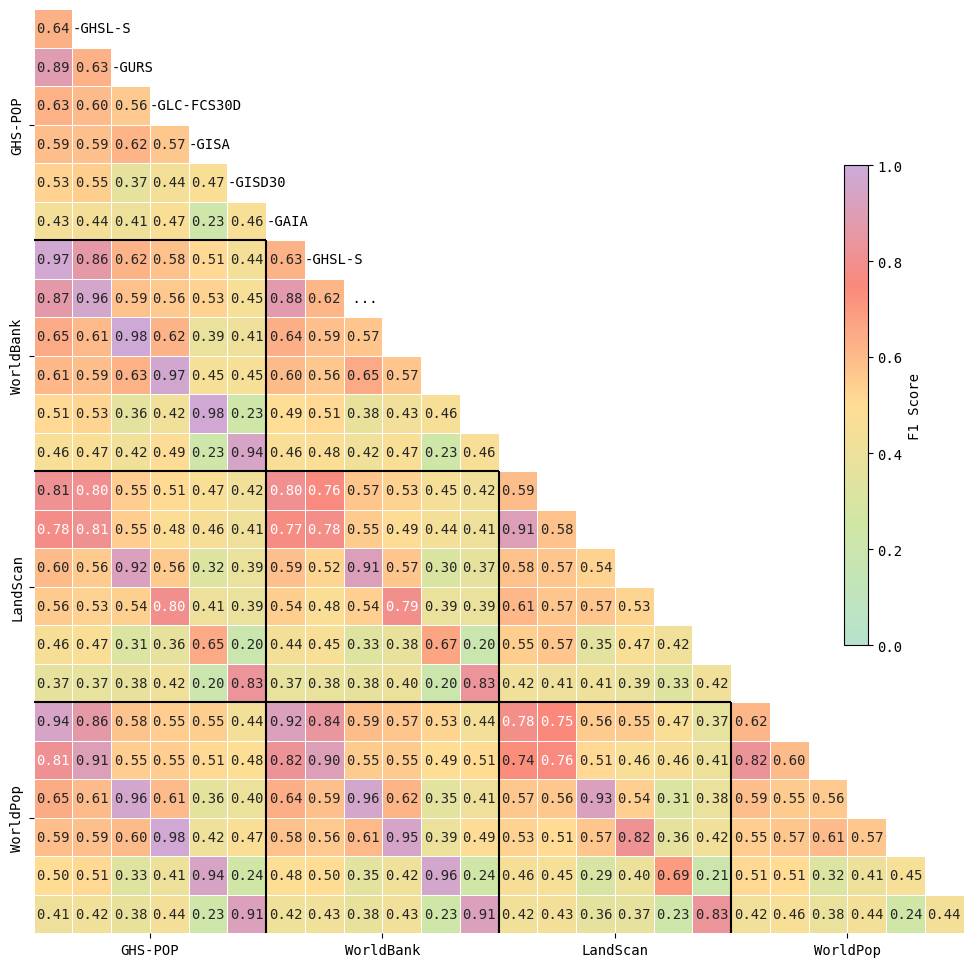

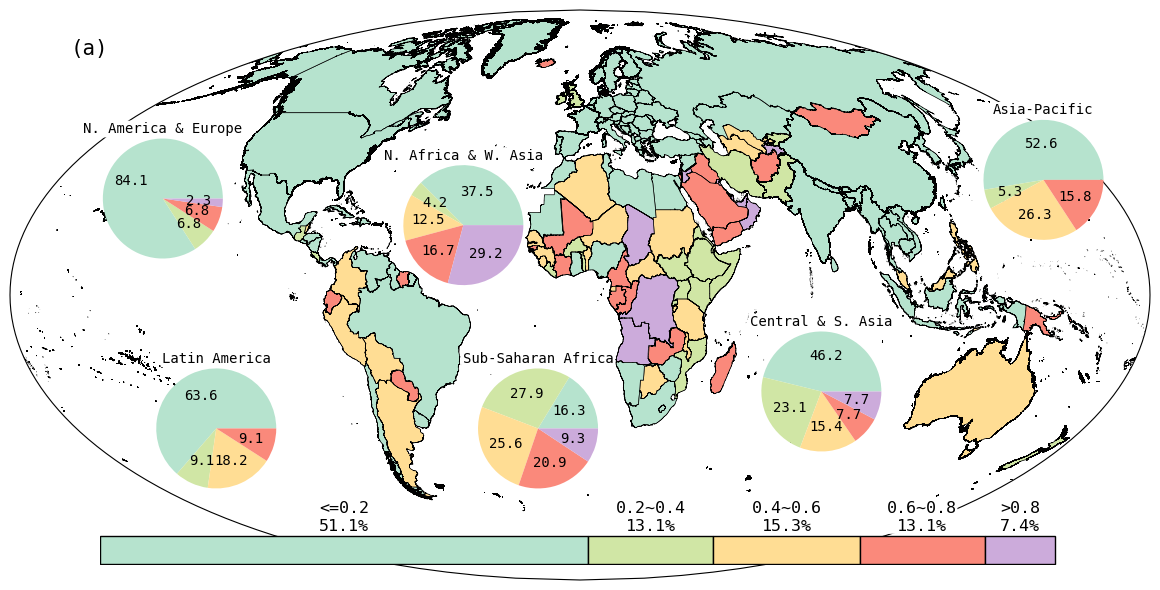

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 假设以下变量提前定义：
# intervals: dict, 例如 {20: [(2020, ...), ...]}
# Area_Prod: list of str, 例如 ['A', 'B', ...]
# Pop_Prod: list of str, 例如 ['X', 'Y', ...]
# df_copy: DataFrame, 包含所有cat_cols
# cmap_: 热力图配色（可以用 'YlGnBu' 或其它seaborn支持的cmap）

interval = 20  # 你要分析的间隔
year = 2020    # 你要分析的年份（可自行替换）

# 1. 生成cat_cols
cat_cols = [
    f'CatLCRPGR_{interval}_{year}_{uprod}&{pprod}'
    for pprod in Pop_Prod for uprod in Area_Prod 
]

# 2. 去除冗余前缀
prefix = 'LCRPGR_{}_{}_' .format(interval, year)
short_names = [col[len(prefix):] if col.startswith(prefix) else col for col in cat_cols]
f1_matrix = np.zeros((len(short_names),len(short_names)))
for i in range(len(short_names)):
    for j in range(len(short_names)):
        comb1 = cat_cols[i]
        comb2 = cat_cols[j]
        if i==j:
            f1_matrix[i,j] = 1
        else:
            f1_matrix[i,j] = f1_score(df_copy[comb1].values,df_copy[comb2].values)
Cat_20_2020_weight = (f1_matrix.sum(0)-1)/(len(Area_Prod)*len(Pop_Prod)-1)
for i in range(len(short_names)):
    f1_matrix[i,i] = Cat_20_2020_weight[i]
f1_df = pd.DataFrame(f1_matrix, index=short_names, columns=short_names)
Cat_20_2020_weight = (f1_matrix.sum(0)-1)/(len(Area_Prod)*len(Pop_Prod)-1)
mask = np.triu(np.ones_like(f1_df, dtype=bool), k=1)

# 6. 画热力图（带着色条, 可选）
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(
    f1_df,
    annot=True,
    fmt=".2f",
    cmap=cmap_ ,
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar=False,
    # cbar_kws=False,
    mask=mask,
    ax=ax
)
ax.set_xticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=0)
ax.set_yticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=90)
for i in range(len(Pop_Prod)-1):
    ax.vlines(len(Area_Prod)*(i+1),len(Area_Prod)*(i+1),len(Area_Prod)*len(Pop_Prod),colors='k',zorder=2)
    ax.hlines(len(Area_Prod)*(i+1),0 ,len(Area_Prod)*(i+1),colors='k',zorder=2)
for i in range(len(Area_Prod)):
    ax.text(i+1,i+0.5,'-'+Area_Prod[i],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,'-'+Area_Prod[0],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,' ...',ha='left', va='center', )
cbar_ax = fig.add_axes([0.8, 0.35, 0.02, 0.4])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('F1 Score')
# ax.text(0.95, 0.98, f"(a)", fontsize=14, ha='center', va='top', transform=ax.transAxes,
#                   bbox=dict(facecolor='white', edgecolor='none',
#                   boxstyle='round,pad=0.1'))
################################################################
def weight_sum(row,cols,weight):
    values = np.array(row[cols].values)
    weight = weight/weight.sum()
    return np.dot(weight.ravel(), values.ravel())
df_copy['WSCatLCRPGR_20_2020'] = df_copy.apply(weight_sum,axis=1,args=(cat_cols,Cat_20_2020_weight,))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def reclassify_values(value):
    if value <= 0.2:
        return '<=0.2'
    elif value <= 0.4:
        return '0.2~0.4'
    elif value <= 0.6:
        return '0.4~0.6'
    elif value <= 0.8:
        return '0.6~0.8'
    else:
        return '>0.8'
fig, ax  = plot_LCRPGR(df_copy, 'WSCatLCRPGR_20_2020', num='(a)', scale=1.5, classifier=reclassify_values,colors={
    '<=0.2': "#B6E3CE",
    '0.2~0.4': "#D0E6A5",
    '0.4~0.6': "#FFDD94",
    '0.6~0.8': "#FA897B",
    '>0.8': "#CCABDB"},extra_polygon=rows_with_illegal)
df_copy['category30'] = df_copy['WSCatLCRPGR_20_2020'].apply(
    reclassify_values)

# 按 NRID 分组统计分类结果
grouped = df_copy.groupby(
    'NRID')['category30'].value_counts().unstack(fill_value=0)
# 定义一个函数，仅在值大于 0 时返回标注


def autopct_format(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f'{pct:.1f}' if absolute > 0 else ''
categories = ['<=0.2', '0.2~0.4', '0.4~0.6', '0.6~0.8', '>0.8']
colors = [
        "#B6E3CE",
        "#D0E6A5",
        "#FFDD94",
        "#FA897B",
        "#CCABDB"]
grouped = grouped.reindex(columns=categories, fill_value=0)
# 绘制每个分组的饼图
# 绘制每个分组的饼图
disp_xy = {1:[160,30],2:[-140,25],3:[-130,-35],4:[-38,18],5:[-15,-35],6:[81,-25]}
for nrid, group in grouped.iterrows():
    # 数据
    labels = group.index
    sizes = group.values
    disp_x, disp_y = disp_xy[nrid]
    disp_x, disp_y = ax.projection.transform_point(disp_x, disp_y, ccrs.PlateCarree())
    # 绘图
    inset_ax = inset_axes(
    ax,
    width=1.5,  # fraction of map width
    height=1.5, # fraction of map height
    loc='center',
    bbox_to_anchor=(disp_x, disp_y),
    bbox_transform=ax.transData,
    borderpad=0
)
    # plt.figure(figsize=(3, 3))
    inset_ax.pie(
        sizes,
        # labels=labels,
        autopct=lambda pct: autopct_format(pct, sizes),  # 自定义标注格式
        startangle=0,
        colors=colors,  # 使用固定顺序的颜色
        textprops={'fontsize': 10} 
    )
    inset_ax.set_aspect('equal')
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_frame_on(False)
    # inset_ax.set_title(f"{rid_to_region[nrid]}",fontsize=10,pad=0)
    inset_ax.text(0.5, 1.01, f"{nrid2nregion[nrid]}", fontsize=10, ha='center', va='top', transform=inset_ax.transAxes,
                  bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1'))

## LUE trend 2000\~2010 vs. 2010\~2020

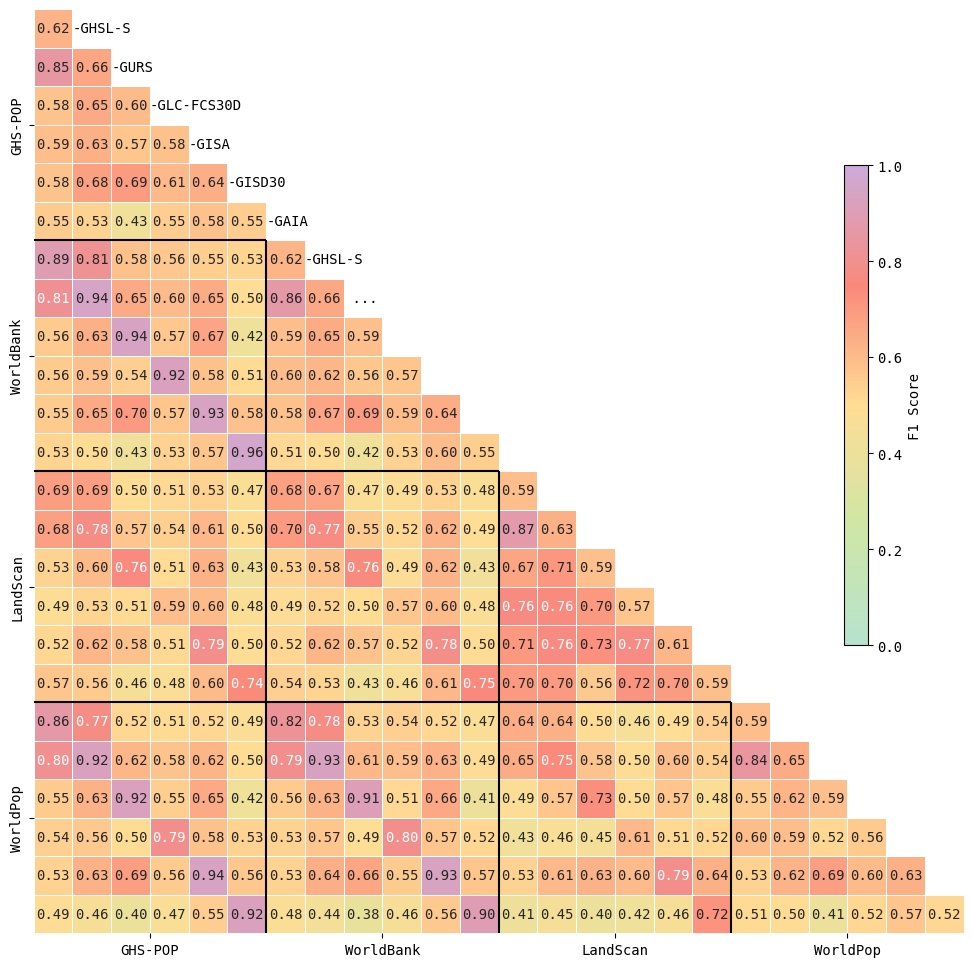

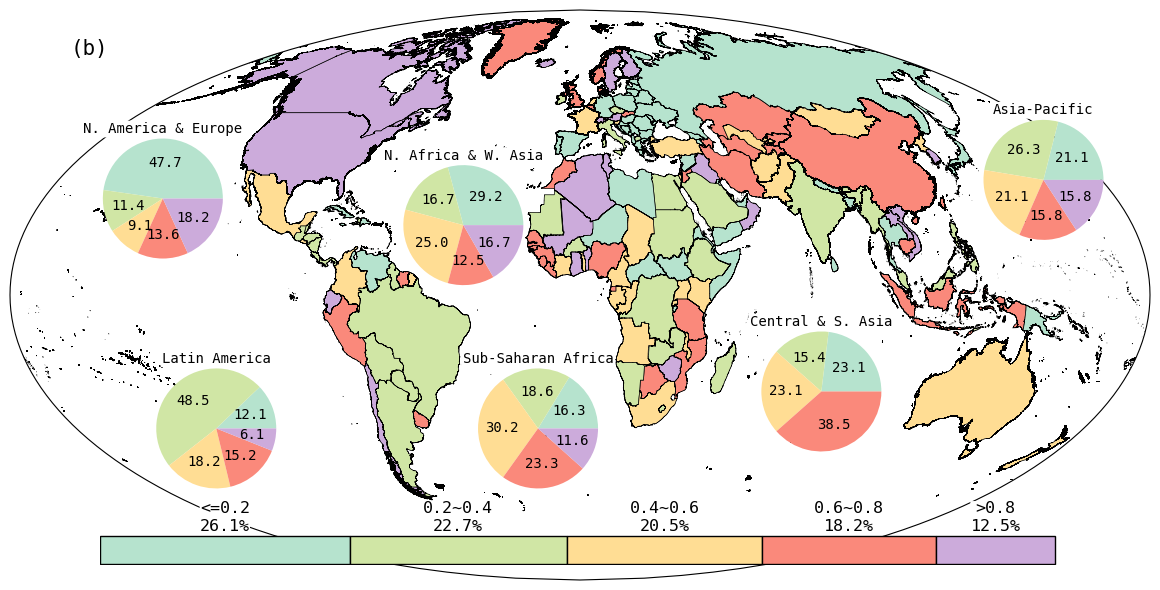

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 假设以下变量提前定义：
# intervals: dict, 例如 {20: [(2020, ...), ...]}
# Area_Prod: list of str, 例如 ['A', 'B', ...]
# Pop_Prod: list of str, 例如 ['X', 'Y', ...]
# df_copy: DataFrame, 包含所有cat_cols
# cmap_: 热力图配色（可以用 'YlGnBu' 或其它seaborn支持的cmap）

interval = 10  # 你要分析的间隔
year = 2020    # 你要分析的年份（可自行替换）

# 1. 生成cat_cols
cat_cols = [
    'Trend'+f'LCRPGR_{interval}_{uprod}&{pprod}'
    for pprod in Pop_Prod for uprod in Area_Prod 
]

# 2. 去除冗余前缀
prefix = 'LCRPGR_{}_' .format(interval, year)
short_names = [col[len(prefix):] if col.startswith(prefix) else col for col in cat_cols]
f1_matrix = np.zeros((len(short_names),len(short_names)))
for i in range(len(short_names)):
    for j in range(len(short_names)):
        comb1 = cat_cols[i]
        comb2 = cat_cols[j]
        if i==j:
            f1_matrix[i,j] = 1
        else:
            f1_matrix[i,j] = f1_score(df_copy[comb1].values,df_copy[comb2].values)
Trend_20_weight = (f1_matrix.sum(0)-1)/(len(Area_Prod)*len(Pop_Prod)-1)

for i in range(len(short_names)):
    f1_matrix[i,i] = Trend_20_weight[i]            
f1_df = pd.DataFrame(f1_matrix, index=short_names, columns=short_names)
mask = np.triu(np.ones_like(f1_df, dtype=bool), k=1)

# 6. 画热力图（带着色条, 可选）
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(
    f1_df,
    annot=True,
    fmt=".2f",
    cmap=cmap_ ,
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar=False,
    # cbar_kws=False,
    mask=mask,
    ax=ax
)
ax.set_xticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=0)
ax.set_yticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=90)
for i in range(len(Pop_Prod)-1):
    ax.vlines(len(Area_Prod)*(i+1),len(Area_Prod)*(i+1),len(Area_Prod)*len(Pop_Prod),colors='k',zorder=2)
    ax.hlines(len(Area_Prod)*(i+1),0 ,len(Area_Prod)*(i+1),colors='k',zorder=2)
for i in range(len(Area_Prod)):
    ax.text(i+1,i+0.5,'-'+Area_Prod[i],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,'-'+Area_Prod[0],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,' ...',ha='left', va='center', )
cbar_ax = fig.add_axes([0.8, 0.35, 0.02, 0.4])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('F1 Score')
# ax.text(0.95, 0.98, f"(b)", fontsize=14, ha='center', va='top', transform=ax.transAxes,
#                   bbox=dict(facecolor='white', edgecolor='none',
#                   boxstyle='round,pad=0.1'))
################################################################
def weight_sum(row,cols,weight):
    values = np.array(row[cols].values)
    weight = weight/weight.sum()
    return np.dot(weight.ravel(), values.ravel())
df_copy['WSTrendLCRPGR_20_2020'] = df_copy.apply(weight_sum,axis=1,args=(cat_cols,Trend_20_weight,))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def reclassify_values(value):
    if value <= 0.2:
        return '<=0.2'
    elif value <= 0.4:
        return '0.2~0.4'
    elif value <= 0.6:
        return '0.4~0.6'
    elif value <= 0.8:
        return '0.6~0.8'
    else:
        return '>0.8'
fig, ax  = plot_LCRPGR(df_copy, 'WSTrendLCRPGR_20_2020', num='(b)', scale=1.5, classifier=reclassify_values,colors={
    '<=0.2': "#B6E3CE",
    '0.2~0.4': "#D0E6A5",
    '0.4~0.6': "#FFDD94",
    '0.6~0.8': "#FA897B",
    '>0.8': "#CCABDB"},extra_polygon=rows_with_illegal)

df_copy['category30'] = df_copy['WSTrendLCRPGR_20_2020'].apply(
    reclassify_values)

# 按 NRID 分组统计分类结果
grouped = df_copy.groupby(
    'NRID')['category30'].value_counts().unstack(fill_value=0)
# 定义一个函数，仅在值大于 0 时返回标注


def autopct_format(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f'{pct:.1f}' if absolute > 0 else ''
categories = ['<=0.2', '0.2~0.4', '0.4~0.6', '0.6~0.8', '>0.8']
colors = [
        "#B6E3CE",
        "#D0E6A5",
        "#FFDD94",
        "#FA897B",
        "#CCABDB"]
grouped = grouped.reindex(columns=categories, fill_value=0)
# 绘制每个分组的饼图
# 绘制每个分组的饼图
disp_xy = {1:[160,30],2:[-140,25],3:[-130,-35],4:[-38,18],5:[-15,-35],6:[81,-25]}
for nrid, group in grouped.iterrows():
    # 数据
    labels = group.index
    sizes = group.values
    disp_x, disp_y = disp_xy[nrid]
    disp_x, disp_y = ax.projection.transform_point(disp_x, disp_y, ccrs.PlateCarree())
    # 绘图
    inset_ax = inset_axes(
    ax,
    width=1.5,  # fraction of map width
    height=1.5, # fraction of map height
    loc='center',
    bbox_to_anchor=(disp_x, disp_y),
    bbox_transform=ax.transData,
    borderpad=0
)
    # plt.figure(figsize=(3, 3))
    inset_ax.pie(
        sizes,
        # labels=labels,
        autopct=lambda pct: autopct_format(pct, sizes),  # 自定义标注格式
        startangle=0,
        colors=colors,  # 使用固定顺序的颜色
        textprops={'fontsize': 10} 
    )
    inset_ax.set_aspect('equal')
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_frame_on(False)
    # inset_ax.set_title(f"{rid_to_region[nrid]}",fontsize=10,pad=0)
    inset_ax.text(0.5, 1.01, f"{nrid2nregion[nrid]}", fontsize=10, ha='center', va='top', transform=inset_ax.transAxes,
                  bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1'))

## LUE trend by BpC

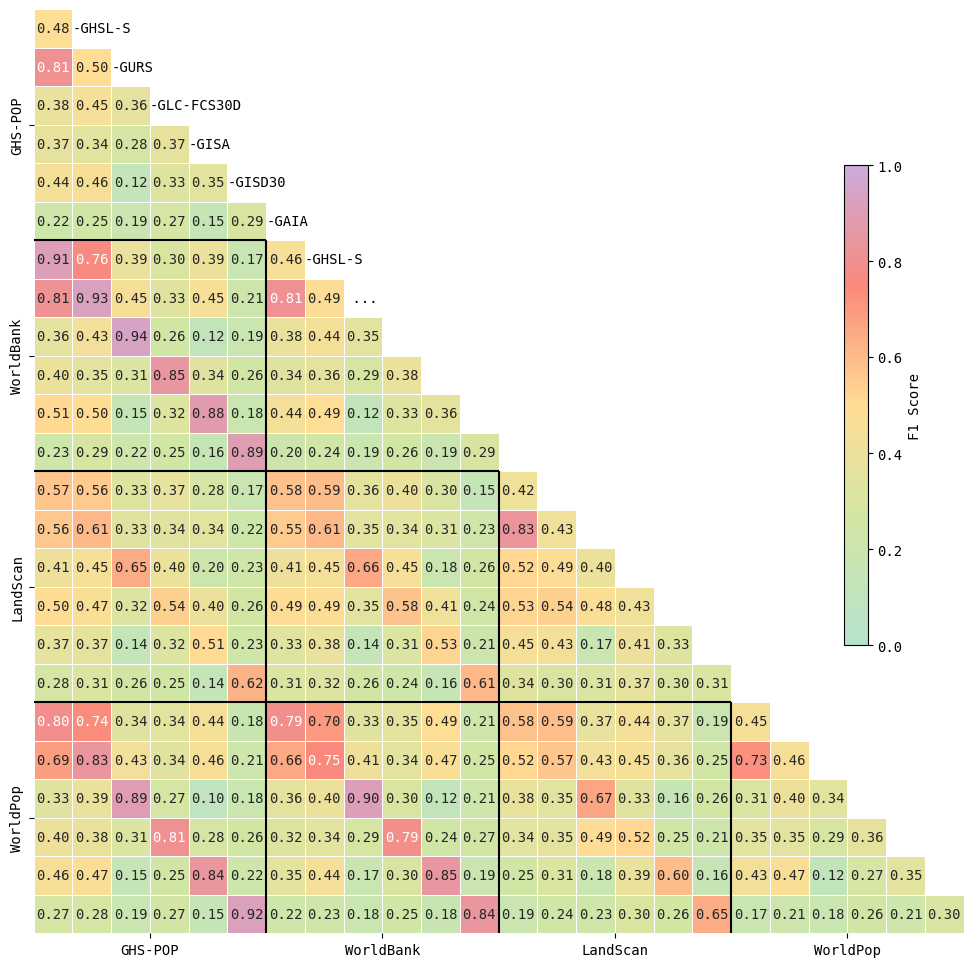

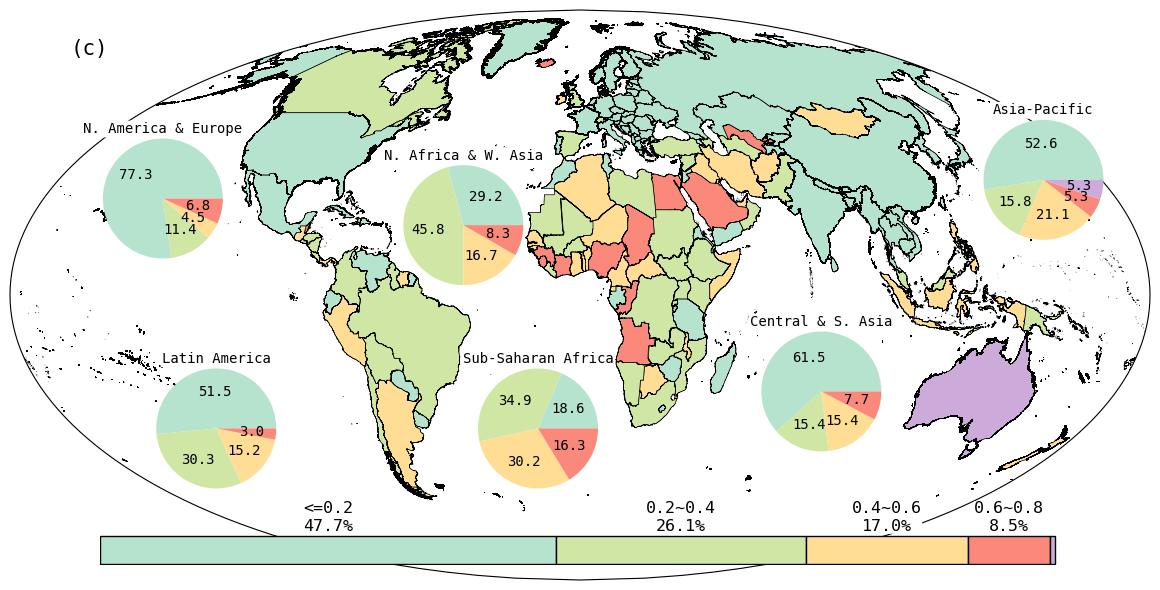

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 假设以下变量提前定义：
# intervals: dict, 例如 {20: [(2020, ...), ...]}
# Area_Prod: list of str, 例如 ['A', 'B', ...]
# Pop_Prod: list of str, 例如 ['X', 'Y', ...]
# df_copy: DataFrame, 包含所有cat_cols
# cmap_: 热力图配色（可以用 'YlGnBu' 或其它seaborn支持的cmap）

interval = 10  # 你要分析的间隔
year = 2020    # 你要分析的年份（可自行替换）

# 1. 生成cat_cols
cat_cols = [
    'Trend'+f'BpC_{uprod}&{pprod}'
    for pprod in Pop_Prod for uprod in Area_Prod 
]

# 2. 去除冗余前缀
prefix = 'BpC_' .format(interval, year)
short_names = [col[len(prefix):] if col.startswith(prefix) else col for col in cat_cols]
f1_matrix = np.zeros((len(short_names),len(short_names)))
for i in range(len(short_names)):
    for j in range(len(short_names)):
        comb1 = cat_cols[i]
        comb2 = cat_cols[j]
        if i==j:
            f1_matrix[i,j] = 1
        else:
            f1_matrix[i,j] = f1_score(df_copy[comb1].values,df_copy[comb2].values)
Trend_BpC_weight = (f1_matrix.sum(0)-1)/(len(Area_Prod)*len(Pop_Prod)-1)
for i in range(len(short_names)):
    f1_matrix[i,i] = Trend_BpC_weight[i]          
f1_df = pd.DataFrame(f1_matrix, index=short_names, columns=short_names)
mask = np.triu(np.ones_like(f1_df, dtype=bool), k=1)

# 6. 画热力图（带着色条, 可选）
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(
    f1_df,
    annot=True,
    fmt=".2f",
    cmap=cmap_ ,
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar=False,
    # cbar_kws=False,
    mask=mask,
    ax=ax
)
ax.set_xticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=0)
ax.set_yticks(np.linspace(1,len(Pop_Prod),len(Pop_Prod))*len(Area_Prod)-len(Pop_Prod)+1,Pop_Prod,rotation=90)
for i in range(len(Pop_Prod)-1):
    ax.vlines(len(Area_Prod)*(i+1),len(Area_Prod)*(i+1),len(Area_Prod)*len(Pop_Prod),colors='k',zorder=2)
    ax.hlines(len(Area_Prod)*(i+1),0 ,len(Area_Prod)*(i+1),colors='k',zorder=2)
for i in range(len(Area_Prod)):
    ax.text(i+1,i+0.5,'-'+Area_Prod[i],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,'-'+Area_Prod[0],ha='left', va='center', )
i+=1
ax.text(i+1,i+0.5,' ...',ha='left', va='center', )
cbar_ax = fig.add_axes([0.8, 0.35, 0.02, 0.4])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('F1 Score')
# ax.text(0.95, 0.98, f"(b)", fontsize=14, ha='center', va='top', transform=ax.transAxes,
#                   bbox=dict(facecolor='white', edgecolor='none',
#                   boxstyle='round,pad=0.1'))
################################################################
def weight_sum(row,cols,weight):
    values = np.array(row[cols].values)
    weight = weight/weight.sum()
    return np.dot(weight.ravel(), values.ravel())
df_copy['WSTrendBpC'] = df_copy.apply(weight_sum,axis=1,args=(cat_cols,Trend_BpC_weight,))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def reclassify_values(value):
    if value <= 0.2:
        return '<=0.2'
    elif value <= 0.4:
        return '0.2~0.4'
    elif value <= 0.6:
        return '0.4~0.6'
    elif value <= 0.8:
        return '0.6~0.8'
    else:
        return '>0.8'
fig, ax  = plot_LCRPGR(df_copy, 'WSTrendBpC', num='(c)', scale=1.5, classifier=reclassify_values,colors={
    '<=0.2': "#B6E3CE",
    '0.2~0.4': "#D0E6A5",
    '0.4~0.6': "#FFDD94",
    '0.6~0.8': "#FA897B",
    '>0.8': "#CCABDB"},extra_polygon=rows_with_illegal)

df_copy['category30'] = df_copy['WSTrendBpC'].apply(
    reclassify_values)

# 按 NRID 分组统计分类结果
grouped = df_copy.groupby(
    'NRID')['category30'].value_counts().unstack(fill_value=0)
# 定义一个函数，仅在值大于 0 时返回标注


def autopct_format(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f'{pct:.1f}' if absolute > 0 else ''
categories = ['<=0.2', '0.2~0.4', '0.4~0.6', '0.6~0.8', '>0.8']
colors = [
        "#B6E3CE",
        "#D0E6A5",
        "#FFDD94",
        "#FA897B",
        "#CCABDB"]
grouped = grouped.reindex(columns=categories, fill_value=0)
# 绘制每个分组的饼图
# 绘制每个分组的饼图
disp_xy = {1:[160,30],2:[-140,25],3:[-130,-35],4:[-38,18],5:[-15,-35],6:[81,-25]}
for nrid, group in grouped.iterrows():
    # 数据
    labels = group.index
    sizes = group.values
    disp_x, disp_y = disp_xy[nrid]
    disp_x, disp_y = ax.projection.transform_point(disp_x, disp_y, ccrs.PlateCarree())
    # 绘图
    inset_ax = inset_axes(
    ax,
    width=1.5,  # fraction of map width
    height=1.5, # fraction of map height
    loc='center',
    bbox_to_anchor=(disp_x, disp_y),
    bbox_transform=ax.transData,
    borderpad=0
)
    # plt.figure(figsize=(3, 3))
    inset_ax.pie(
        sizes,
        # labels=labels,
        autopct=lambda pct: autopct_format(pct, sizes),  # 自定义标注格式
        startangle=0,
        colors=colors,  # 使用固定顺序的颜色
        textprops={'fontsize': 10} 
    )
    inset_ax.set_aspect('equal')
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_frame_on(False)
    # inset_ax.set_title(f"{rid_to_region[nrid]}",fontsize=10,pad=0)
    inset_ax.text(0.5, 1.01, f"{nrid2nregion[nrid]}", fontsize=10, ha='center', va='top', transform=inset_ax.transAxes,
                  bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1'))

## Income and HDI

/tmp/ipykernel_706656/3937217006.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='HDI_Group', y='WSCatLCRPGR_20_2020',
/tmp/ipykernel_706656/3937217006.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='HDI_Group', y='WSTrendLCRPGR_20_2020',
/tmp/ipykernel_706656/3937217006.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='HDI_Group', y='WSTrendBpC',


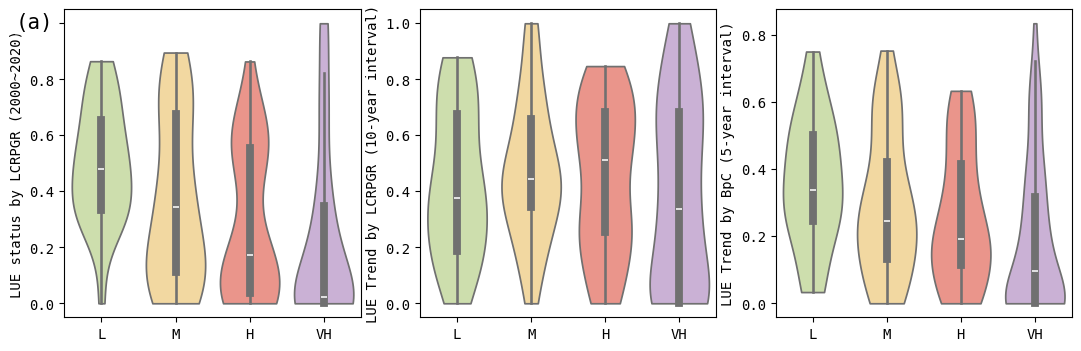

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 定义新的分组边界
bins = [0, 0.55, 0.7, 0.8, 1.0]
labels = [
    'L',
    'M',
    'H',
    'VH'
]

# 按 HDI 分组
df_copy['HDI_Group'] = pd.cut(df_copy['HDI_2023_UNDP'], bins=bins, labels=labels, include_lowest=True)

# 自定义颜色
custom_palette = [ "#D0E6A5", "#FFDD94", "#FA897B", "#CCABDB"]

# 设置画布
fig, ax = plt.subplots(1, 3, figsize=(13,4))

ylable = [
    'LUE status by LCRPGR (2000~2020)',
    'LUE Trend by LCRPGR (10-year interval)',
    'LUE Trend by BpC (5-year interval)'
]
# 绘制风琴图（限制分布范围在 0-1）
sns.violinplot(data=df_copy, x='HDI_Group', y='WSCatLCRPGR_20_2020',
               ax=ax[0], inner='box', palette=custom_palette, cut=0)
sns.violinplot(data=df_copy, x='HDI_Group', y='WSTrendLCRPGR_20_2020',
               ax=ax[1], inner='box', palette=custom_palette, cut=0)
sns.violinplot(data=df_copy, x='HDI_Group', y='WSTrendBpC',
               ax=ax[2], inner='box', palette=custom_palette, cut=0)

# 优化显示
for a,yl in zip(ax,ylable):
    a.set_xlabel("")
    a.set_ylabel(yl)
    a.tick_params(axis='x', rotation=0)

plt.text(
        -0.1, 0.99, f"(a)",
        fontsize=15, color='black',
        ha='center', va='top',
        transform=ax[0].transAxes,
        bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1')
    )
# plt.tight_layout()
plt.show()

/tmp/ipykernel_706656/2706910407.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='IG_Group', y='WSCatLCRPGR_20_2020',
/tmp/ipykernel_706656/2706910407.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='IG_Group', y='WSTrendLCRPGR_20_2020',
/tmp/ipykernel_706656/2706910407.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_copy, x='IG_Group', y='WSTrendBpC',


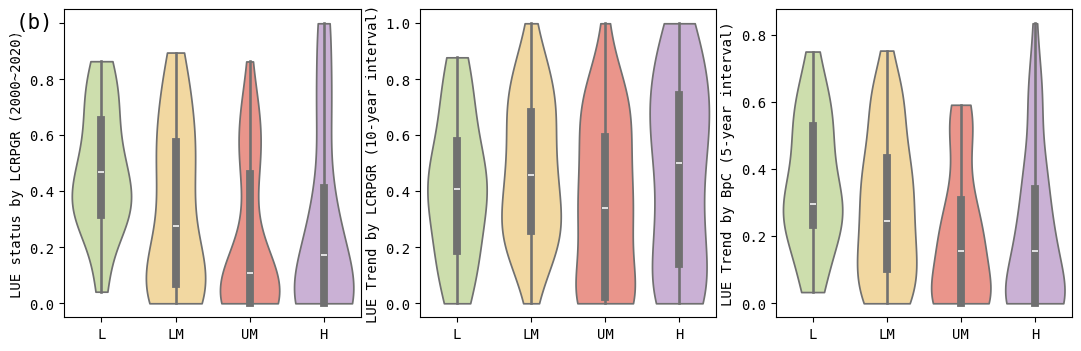

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels = {
    1:'L',
    2:'LM',
    3:'UM',
    4:'H'
}

# 按 HDI 分组
df_copy['IG_Group'] = df_copy['IG_2020_WorldBank'].map(labels)

# 自定义颜色
custom_palette = [ "#D0E6A5", "#FFDD94", "#FA897B", "#CCABDB"]

# 设置画布
fig, ax = plt.subplots(1, 3, figsize=(13,4))

# 绘制风琴图（限制分布范围在 0-1）
sns.violinplot(data=df_copy, x='IG_Group', y='WSCatLCRPGR_20_2020',
               ax=ax[0], inner='box', palette=custom_palette, cut=0)
sns.violinplot(data=df_copy, x='IG_Group', y='WSTrendLCRPGR_20_2020',
               ax=ax[1], inner='box', palette=custom_palette, cut=0)
sns.violinplot(data=df_copy, x='IG_Group', y='WSTrendBpC',
               ax=ax[2], inner='box', palette=custom_palette, cut=0)

# 优化显示
for a,yl in zip(ax,ylable):
    a.set_xlabel("")
    a.set_ylabel(yl)
    a.tick_params(axis='x', rotation=0)

plt.text(
        -0.1, 0.99, f"(b)",
        fontsize=15, color='black',
        ha='center', va='top',
        transform=ax[0].transAxes,
        bbox=dict(facecolor='white', edgecolor='none',
                  boxstyle='round,pad=0.1')
    )
plt.tight_layout()
plt.show()